In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from processinggps import *
import numpy as np
from scipy.signal import fftconvolve

# Lecture données

In [2]:
filename='gpssim.bin'
data = np.fromfile(filename,dtype=np.byte)
# Mise en forme complexe des échantillons I et Q
re=data[0::2]
im = data[1::2]
r = re+1j*im

In [3]:
# Doppler
Nfd = 100
fdmax = 5000
fs = 2600000
fd = np.linspace(-1,1,Nfd)* (fdmax/fs)

In [5]:
def correlate(rc,csat,fd):
    """
    rc : complex signal IQ samples
    csat : code pseudo aléatoire échantillonné à fs
    """
    t = np.arange(0,len(rc) )
    rr = rc[None,:]*np.exp(-1j*2*np.pi*t*fd[:,None])
    RR = np.fft.fft(rr)
    CSAT = np.fft.fft(csat)
    U = np.fft.ifft(RR* np.conj(CSAT[None,:]))
    return(U)

In [6]:
def codesat(isat,repeatno=200,fs=2600000,fsca=1.023e6):
    """ Construit un motif du code PRN du satellite à la bonne fréquence d'ech
    
    Parameters
    ----------
    isat : satellite number 
    repeatno : int number of code repetition 
    fs   : sampling frequency
    fsca : frequence code C/A
    Returns
    -------
    csat : repetion of C/A code (sampled @ fs)
    
    """
    sat = np.array( PRN(isat) ) # code PRN du satellite
    satind  =  np.floor( np.linspace(0, len(sat)-1, num=int((fs/fsca)* len(sat)) )     ).astype(int)
    satrep  = sat[satind]
    csat = np.tile(satrep,repeatno)
    return(csat)

In [7]:
# Fonction pour identifier les satellites présents dans le signal
def identify_satellites(signal,fd,repeatno=20):
    # Corrélation croisée entre le signal et les codes C/A des satellites connus
    correlations = []
    largmax = []
    for sat_num in range(1,32):
        csat = codesat(sat_num,repeatno=repeatno)
        rc = signal[0:len(csat)]
        U = correlate(rc,csat,fd)
        corrmax = np.max(np.abs(U))
        a = np.where(np.abs(U)==corrmax)
        correlations.append(corrmax)
        largmax.append(a)
        #correlation = np.abs(fftconvolve(signal, code[::-1], mode='same'))
    # Identifier les pics de corrélation pour déterminer les satellites présents
    threshold = 0.5 * np.max(correlations)
    detected_satellites = [i+1 for i, corr in enumerate(correlations) if corr > threshold]
    largmax = [ largmax[i-1] for i in detected_satellites ]
    largmax = [ (a[0][0],a[1][0]) for a in largmax ]
    return detected_satellites,correlations,largmax

In [8]:
detected_satellites,correlations,larg = identify_satellites(r,fd)

Text(0, 0.5, 'Correlation value')

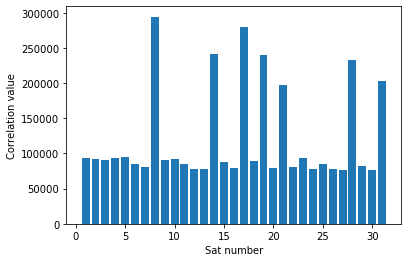

In [9]:
plt.bar(np.arange(1,32),correlations)
plt.xlabel('Sat number')
plt.ylabel('Correlation value')

In [37]:
def fine_Doppler(signal,detected_satellites,fd,larg,Nfd=100,kstart=0,repeatno=20):
    correlations = []
    lfineDoppler =[] 
    for k,sat_num in enumerate(detected_satellites):
        csat = codesat(sat_num,repeatno=repeatno)
        idxfdsat = larg[k][0]
        fdsat  = np.linspace(fd[idxfdsat-1],fd[idxfdsat+1],Nfd)
        rc = signal[kstart:len(csat)+kstart]
        U = correlate(rc,csat,fdsat)
        corrmax = np.max(np.abs(U))
        a = np.where(np.abs(U)==corrmax)
        correlations.append(corrmax)
        lfineDoppler.append(fdsat[a[0][0]])
    return lfineDoppler,correlations

array([        0,  86632000, 173264000, 259896000, 346528000, 433160000,
       519792000, 606424000, 693056000, 779688000])

In [65]:

for k,kstart in enumerate(np.linspace(0,len(r)-len(csat),30).astype(int)):
    print(k)
    lfineDoppler,fdoppcorr = fine_Doppler(r,detected_satellites,fd,larg,kstart=kstart)
    try: 
        tfDoppler = np.hstack((tfDoppler,np.array(lfineDoppler)[None,:]))
    except:
        tfDoppler = np.array(lfineDoppler)[None,:]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [70]:
tfDoppler = tfDoppler[70:]

In [71]:
A = tfDoppler.reshape(30,7).T

ValueError: cannot reshape array of size 0 into shape (30,7)

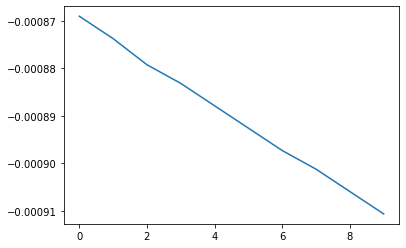

In [64]:
plt.plot(A[1,:])

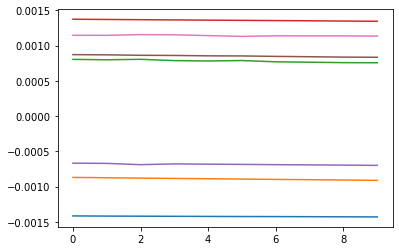

In [62]:
for isat in np.arange(7):
    plt.plot(A[isat,:])

In [44]:
csat = codesat(8,repeatno=20)

In [48]:
len(r)/10

77974000.0

In [45]:
len(csat)

52000

In [39]:
lfineDoppler

[-0.0014152794455824758,
 -0.0008690243538728386,
 0.0008054515630273209,
 0.0013748597081930417,
 -0.0006669256669256669,
 0.0008729486002213278,
 0.0011472534199806932]

In [41]:
fd[13]

-0.0014180264180264181

In [ ]:
# Initialisation des paramètres
frequency_doppler = initial_doppler
code_shift = initial_code_shift

# Boucle de suivi
for sample in signal:
    # Appliquer le décalage du code et la compensation Doppler
    synchronized_signal = apply_doppler_and_code_shift(signal, code_shift, frequency_doppler)
    
    # Calculer les corrélations early, on-time, late
    correlation_early = calculate_correlation(synchronized_signal, early_code_samples)
    correlation_on_time = calculate_correlation(synchronized_signal, on_time_code_samples)
    correlation_late = calculate_correlation(synchronized_signal, late_code_samples)
    
    # Mettre à jour la fréquence Doppler et le décalage du code
    frequency_doppler, code_shift = update_tracking(correlation_early, correlation_on_time, correlation_late, frequency_doppler, code_shift)
    
    # Utiliser frequency_doppler et code_shift pour ajuster le signal et extraire les données


In [61]:
s = np.array([ 1786,  4386,  6986,  9586, 12186, 14786, 17386, 22586, 25186,27786, 32986, 38186, 43386, 48586])

In [62]:
s[1:]-s[0:-1]

array([2600, 2600, 2600, 2600, 2600, 2600, 5200, 2600, 2600, 5200, 5200,
       5200, 5200])

In [58]:
larg[1:3]

[(array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]),
  array([ 1786,  4386,  6986,  9586, 12186, 14786, 17386, 22586, 25186,
         27786, 32986, 38186, 43386, 48586])),
 (array([62, 62, 62]), array([ 2189,  7389, 17789]))]

In [ ]:
# Fonction pour synchroniser le signal sur un satellite particulier
def synchronize_signal(signal, code, doppler_shift):
    # Compenser le décalage du code
    synchronized_signal = np.roll(signal, -offset)
    # Appliquer la compensation Doppler
    # Vous pouvez utiliser une fonction de compensation Doppler appropriée ici
    return synchronized_signal

# Fonction pour extraire la séquence binaire d'un signal synchronisé
def extract_binary_sequence(synchronized_signal, code_length):
    # Implémentez votre méthode d'extraction de séquence binaire ici
    pass

# Paramètres
num_satellites = 32
code_length = 1023  # Longueur du code C/A
doppler_shift = 0   # Décalage Doppler initial (à adapter)

# Exemple de signal GPS
signal_I = np.random.rand(10000)  # Échantillon I du signal
signal_Q = np.random.rand(10000)  # Échantillon Q du signal

# Identifier les satellites présents dans le signal
detected_satellites = identify_satellites(signal_I + 1j * signal_Q, code_length)

# Synchroniser et extraire la séquence binaire pour chaque satellite détecté
for satellite_num in detected_satellites:
    code = generate_CA_code(satellite_num)
    synchronized_signal = synchronize_signal(signal_I + 1j * signal_Q, code, doppler_shift)
    binary_sequence = extract_binary_sequence(synchronized_signal, code_length)
    print(f"Satellite {satellite_num}: Binary sequence {binary_sequence}")


In [7]:
!ls

 2019_12_13_433_MS1	  GPS-LOR1-1-10-2020    processinggps.py
 2019_12_13_433_MS2	  GPSManip	        __pycache__
 2019_12_13_GPS_SB1	  gps.py	        read_data1.py
 2019_12_13_GPS_SB2	  gpssim.bin	        read_data2.py
 2019_12_INSA_1.zip	  ipython_log.py        read_data3.py
 2019_12_INSA_2.zip	  LABSTIC-GPS	        read_data.py
 brdc0180.24n		  logSB1.txt	        tmp
 DemodulationGPS2.ipynb   logSB2.txt
 DemodulationGPS.ipynb	 'pièces jointes.zip'


# Lecture Fichier GPS en bande de bae

$r$ est le signal complex reçu

In [4]:
fs = 2600000     # frequence d'échantillonage
fsca = 1.023e6   # fréquence chip 1MHz
#t = np.linspace(0,len(r)/fs,len(r))  # base de temps signal

In [23]:
300*fs-len(r)

260000

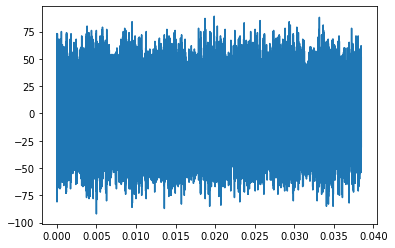

In [14]:
plt.plot(t[0:100000],re[0:100000])

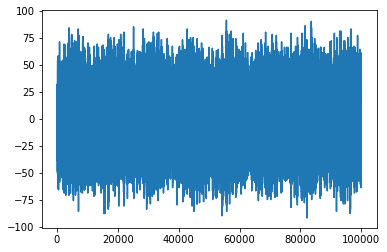

In [39]:
plt.plot(im[0:100000])

In [17]:
Nfd = 100
fdmax = 5000
fs = 2600000

Creation d'une plage d'exploration Doppler

In [77]:
sat = np.array( PRN(1) ) 
satind  =  np.floor( np.linspace(0, len(sat)-1, num=int((fs/fsca)* len(sat)) )     ).astype(int)

In [79]:
satrep=sat[satind]

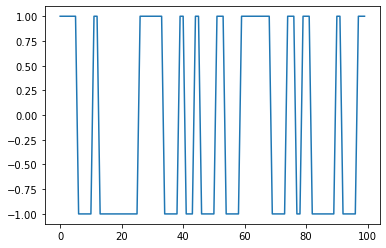

In [83]:
plt.plot(satrep[0:100])

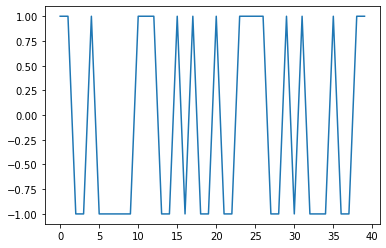

In [85]:
plt.plot(sat[0:40])

In [18]:
fd = np.linspace(-1,1,Nfd)* (fdmax/fs)

In [5]:
fd = np.linspace(-3800/fs,-3500/fs,100)

In [22]:
fd[14]*fs

-3585.8585858585857

In [99]:
tu = []
for isat in range( 8 ,  9 ):
    sat = np.array( PRN(isat) ) # code PRN du satellite
    repeatno= 20
    satind  =  np.floor( np.linspace(0, len(sat)-1, num=int((fs/fsca)* len(sat)) )     ).astype(int)
    satrep  = sat[satind]
    csat = np.tile(satrep,repeatno)
    if  len(csat)  >  len(r) :
        csat = csat[0:len(r)]

    rc = r[0:len(csat)]
    t = np.arange(0,len(rc) )

    rr = rc[None,:]*np.exp(-1j*2*np.pi*t[None,:]*fd[:,None])
    YE = np.fft.fft(rr,axis= 1)

    CSAT = np.fft.fft(csat)

    U = np.fft.ifft(YE* np.conj(CSAT[None,:]),axis= 1)
    tu.append(np.max(np.abs(U)))
    #print(isat,)
    #plt.figure('GPS number = ' + str(isat),figsize=(20,20))
    #plt.subplot(211)
    #plt.title('GPS number = ' + str(isat))
    #plt.imshow(np.abs(U)     ,cmap='jet') #  , vmin =  0 ,  vmax= 30
    #plt.axis('auto')
    #plt.colorbar()
    #plt.show()

# Satellite N°8

In [33]:
csat = bitsat(8)
rc1 = r[0:len(csat)]
rc2 = r[len(csat):2*len(csat)]
t = np.arange(0,len(rc1) )

In [34]:
Y1=correlate(rc1,bitsat(8),fd)

In [35]:
Y2=correlate(rc2,bitsat(8),fd)

In [40]:
u1 = np.where(np.abs(Y1)>np.max(np.abs(Y1))-100)

In [41]:
u2 = np.where(np.abs(Y2)>np.max(np.abs(Y2))-100)

In [43]:
u1

(array([39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]),
 array([  2211,   4811,   7411,  10011,  12611,  15211,  17811,  20411,
         23011,  25611,  28211

In [92]:
a=np.array([1,2,3,4])

In [45]:
crc1=rc1*np.exp(-1j*2*np.pi*t*fd[39])

In [48]:
len(csat)

520000

In [49]:
crc1=crc1*np.roll(csat,2211)

In [23]:
np.sum(crc1[0:2211])

(-15011.82439728486+495.3419105566158j)

In [25]:
np.sum(crc1[2211:4811])

(-16236.48066266818+2512.1426885985743j)

In [26]:
np.sum(crc1[7411:10011])

(-14054.077008980814+3507.5383650309873j)

In [27]:
np.sum(crc1[10011:12611])

(-14690.093756594077+3198.7929591495617j)

In [50]:
s = np.add.reduceat(crc1, u1[1])

In [10]:
plt.plot(np.real(s),np.imag(s))

NameError: name 's' is not defined

In [82]:
u2

(array([39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39]),
 array([ 2211,  4811,  7411, 10011, 12611, 15211, 17811, 20411, 23011,
        25611, 28211, 30811, 33411, 36011, 38611, 41211, 43811, 46411,
        49011, 51611]))

(-0.5, 51999.5, 99.5, -0.5)

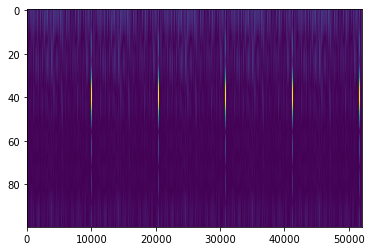

In [75]:
plt.imshow(np.abs(Y2))
plt.axis('auto')

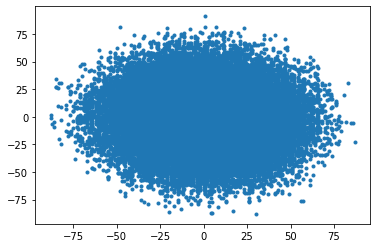

In [55]:
plt.plot(np.real(rc),np.imag(rc),'.')

In [52]:
fd[27]

-0.00143006993006993

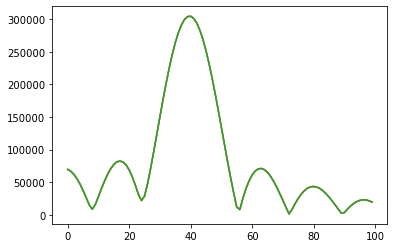

In [44]:
#plt.imshow(np.abs(Y))
plt.plot(np.abs(Y)[:,2211])
plt.plot(np.abs(Y)[:,7411])
plt.plot(np.abs(Y)[:,51611])

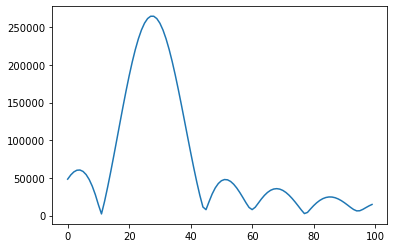

In [51]:
plt.plot(np.abs(Y)[:,17043])

In [119]:
len(bitsat(8))/fs

0.02

(array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]),
 array([ 2211,  4811,  7411, 12611, 15211, 17811, 20411, 23011, 28211,
        30811, 33411, 38611, 41211, 43811, 49011, 51611]))

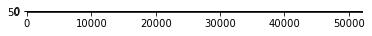

In [111]:
plt.imshow(np.abs(U),cmap='hot')

np.where(np.abs(U)==np.max(np.abs(U)))

In [112]:
U[13,2211]

(-275315.30165930296-104638.10511401236j)

In [127]:
fd[12:15]

array([-0.00145688, -0.00141803, -0.00137918])

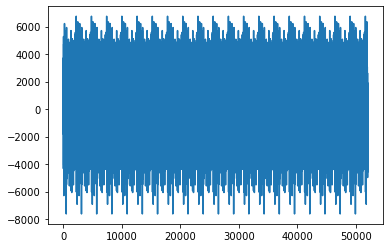

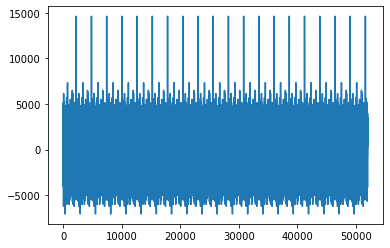

In [126]:
plt.plot(np.imag(U[14]))
plt.figure()
plt.plot(np.real(U[14]))

In [64]:
cA1=1-2*np.random.randint(0,2,1023)
cA2=1-2*np.random.randint(0,2,1023)

In [65]:
c1=PRN(1)

In [66]:
c2=PRN(2)

In [38]:
cc1=np.fft.ifft(np.fft.fft(c1)*np.conj(np.fft.fft(c1)))

In [51]:
def xcorr(c1,c2):
    cc = np.fft.ifft(np.fft.fft(c1)*np.conj(np.fft.fft(c2)))
    return(np.real(cc))

In [57]:
cc1=xcorr(c1,c1)

In [54]:
ccA=xcorr(cA,cA)

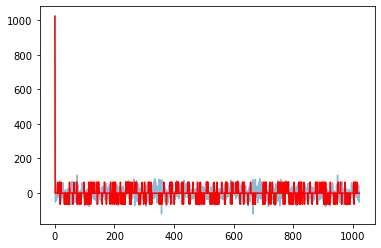

In [59]:
plt.plot(ccA,alpha=0.5)
plt.plot(cc1,'r')

In [61]:
cc1[0]=0

In [63]:
cc1

array([ 0., -1., -1., ..., -1., -1., -1.])

In [72]:
ccA12=xcorr(cA1,cA2)
cc12=xcorr(c1,c2)

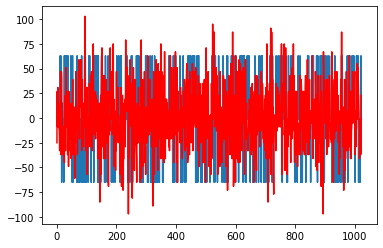

In [74]:
plt.plot(cc12)
plt.plot(ccA12,'r')